## **Aplicação de XGBoost Regression**
Neste notebook será aplicado o modelo XGBoost Regression utilizando as features extraídas dos dados.
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos demais modelos testados até agora. 

In [1]:
# confirgurando diretório
import os
os.chdir("..")

import path
path.config()

# importando bibliotecas
import warnings
from tqdm import tqdm
import pandas as pd
from xgboost import XGBRegressor
from main.features import add_calendar_features
from main.features import add_lagged_features
from main.evaluation import Evaluation
from main.plots import plot_metrics
from main.plots import plot_time_series

# configurando notebook
tqdm.pandas()

warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.2f' % x)

%load_ext autoreload
%autoreload 2

EVAL_PATH = 'notebooks/data/evaluation.csv'

## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [2]:
# leitura dos dados
train_df = pd.read_csv("notebooks/data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("notebooks/data/test_df.csv", parse_dates=['ds'])

## **Feature Engineering**

In [3]:
features_train_df = (
    train_df.groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
).reset_index(drop=True)

features_test_df = (
    test_df.groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
).reset_index(drop=True)


In [4]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter'],
      dtype='object')

In [5]:
# inserindo os lags nos dados de treino e teste

kwargs = {
    'features' : ['feriado', 'month_end'],
    'lags' : [-3, -2, -1, 1, 2, 3]
}

features_train_df = (
    features_train_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

features_test_df = (
    features_test_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

In [6]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'feriado_lag-3', 'feriado_lag-2',
       'feriado_lag-1', 'feriado_lag1', 'feriado_lag2', 'feriado_lag3',
       'month_end_lag-3', 'month_end_lag-2', 'month_end_lag-1',
       'month_end_lag1', 'month_end_lag2', 'month_end_lag3'],
      dtype='object')

## **XGBoost Regression**

In [13]:
def xgb_regressor(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo XGBoost Regressor.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = features_test_df.query(
        "unique_id == @train.unique_id[0]"
    ).reset_index(drop=True)

    train['trend'] = train.index
    fcst_df['trend'] = fcst_df.index + train.index.max() + 1
    
    m = XGBRegressor(
        n_estimators=2000, learning_rate=0.2,
    )
    
    m.fit(
        X=train.iloc[:,3:], y=train.y
    )
    
    fcst_df['y_pred'] = m.predict(fcst_df.iloc[:,3:])

    return fcst_df

In [14]:
# aplicando modelo para cada série
xgb_fcst = features_train_df.groupby("unique_id").apply(xgb_regressor).reset_index(drop=True)

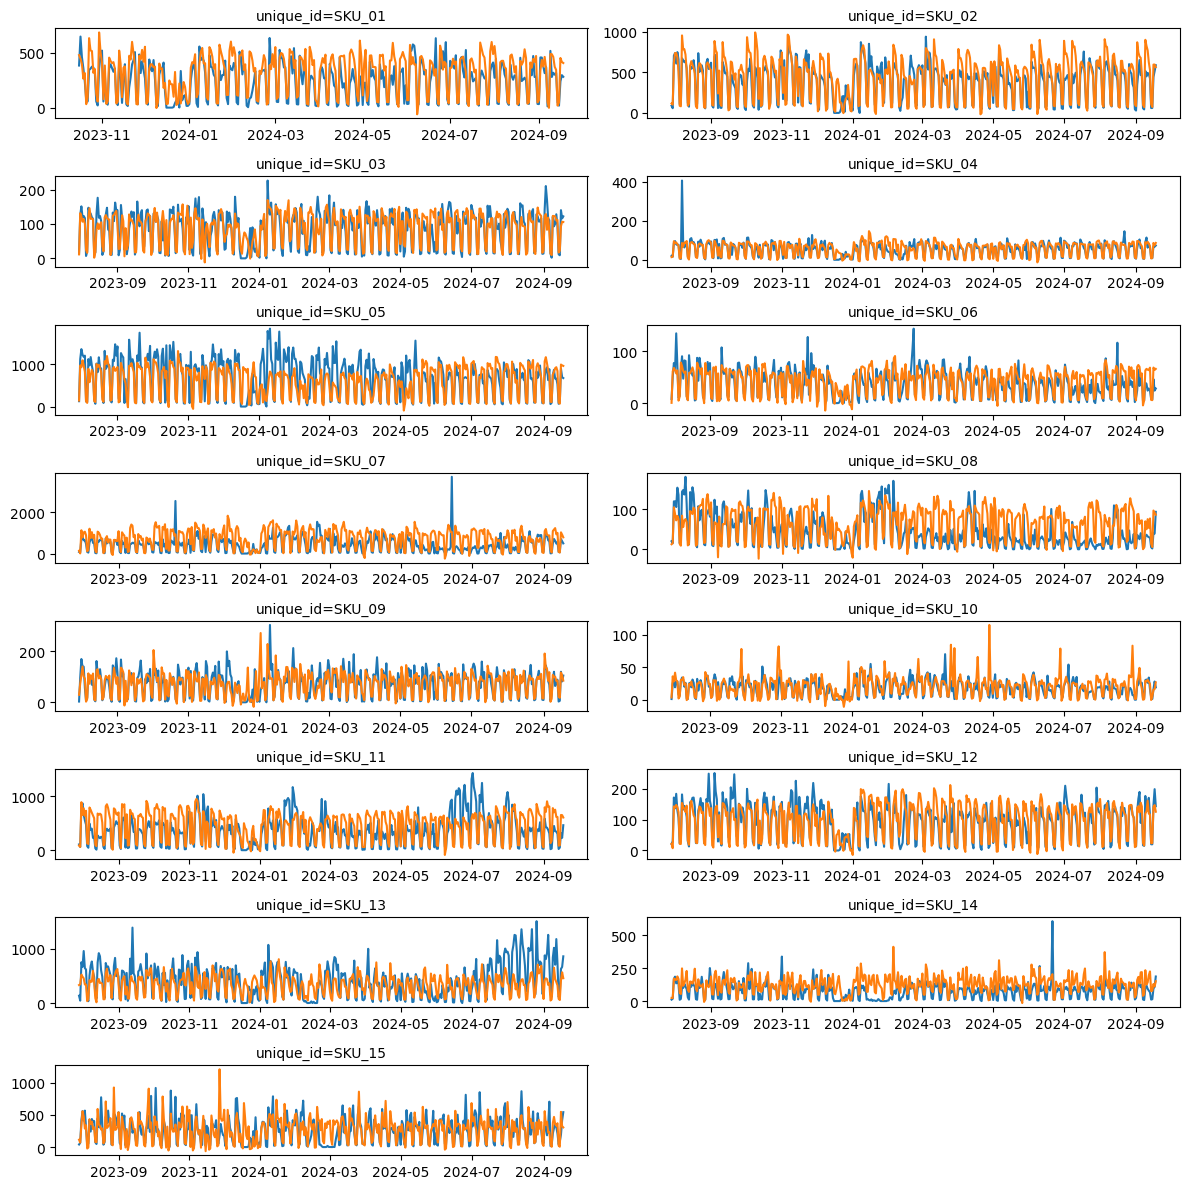

In [15]:
plot_time_series(
    df = xgb_fcst,
    data_cols=['y','y_pred'],
    time_col='ds',
    grid=(8, 2),
    figsize=(12, 12)
)

In [16]:
rf_eval = Evaluation(xgb_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'XGBoost [+Lags]')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,98.65,17171.71,131.04,0.39
SKU_02,106.30,22297.43,149.32,0.57
SKU_03,22.34,922.84,30.38,0.67
SKU_04,15.61,686.10,26.19,0.53
SKU_05,232.82,111996.39,334.66,0.48
SKU_06,14.61,391.64,19.79,0.44
SKU_07,373.09,241138.87,491.06,-0.68
SKU_08,35.24,2004.11,44.77,-0.19
SKU_09,24.57,1371.63,37.04,0.48
SKU_10,7.81,190.35,13.80,-0.19


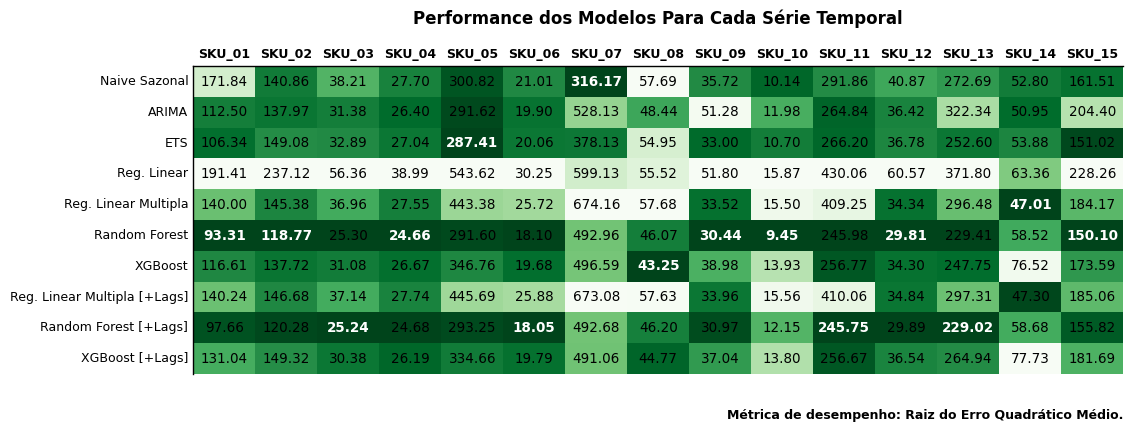

In [ ]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)
order = metrics['model'].unique()
metrics = metrics.pivot_table('rmse','unique_id','model')[order]

fig = plot_metrics(metrics, figsize=(12, 4))